<a href="https://colab.research.google.com/github/pranav-kaushal/NLP/blob/main/Twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

API account
https://developer.twitter.com/en/portal/dashboard

In [19]:
# Install Libraries
#!pip install textblob
#!pip install tweepy
#!pip install langdetect
#!pip install nltk

In [20]:
# Import Libraries

from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
#import pycountry
import re
import string

from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

In [21]:
nltk.downloader.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [22]:
# Authentication
consumerKey = "********"
consumerSecret = "********"
accessToken = "*********"
accessTokenSecret = "*******"

auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [23]:
#Sentiment Analysis

def percentage(part,whole):
    return 100 * float(part)/float(whole) 

keyword = input("Please enter keyword or hashtag to search: ")
noOfTweet = int(input ("Please enter how many tweets to analyze: "))


tweets = tweepy.Cursor(api.search, q=keyword).items(noOfTweet)
positive  = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

for tweet in tweets:
    
    #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1

    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1

positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

Please enter keyword or hashtag to search: scotiabank
Please enter how many tweets to analyze: 100


In [24]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print("total number: ",len(tweet_list))
print("positive number: ",len(positive_list))
print("negative number: ", len(negative_list))
print("neutral number: ",len(neutral_list))

total number:  100
positive number:  20
negative number:  10
neutral number:  70


In [25]:
# to view full text in pandas dataset
pd.set_option('display.max_colwidth', None)

In [26]:
# Renaming 0 column header to tweets
tweet_list.columns = ['tweets']

In [27]:
tweet_list.head(5)

tweets
0      Esto es realmente un sueño hecho realidad! Nuestro indice de sustentabilidad corporativa en el que trabajamos 5 año… https://t.co/Iw2RTgfbMs
1                    @MartinDevon @JeffMarek @wyshynski @espn @JeffMarek took over for @darenmillard on @scotiabank Wednesday Night Hockey in 2018.
2    RT @NHL: 🍁 OH, CANADA! 🍁\n\nThe @MapleLeafs are the first in the @scotiabank North Division to clinch a spot in the #StanleyCup Playoffs! htt…
3    RT @NHL: 🍁 OH, CANADA! 🍁\n\nThe @MapleLeafs are the first in the @scotiabank North Division to clinch a spot in the #StanleyCup Playoffs! htt…
4  It's time to get your cocktail kits (alcoholic &amp; non-alcoholic) ready for the Welcome Reception starting at 5pm EDT… https://t.co/B4S8UXQWT2

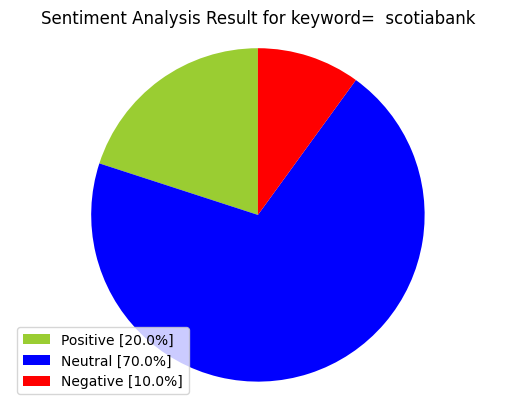

In [28]:
#Creating PieCart

labels = ['Positive ['+str(positive)+'%]' , 'Neutral ['+str(neutral)+'%]','Negative ['+str(negative)+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for keyword=  "+keyword+"" )
plt.axis('equal')
plt.show()

In [29]:
# Dropping duplicates
tweet_list.drop_duplicates(inplace = True)


## Extracting text values

text_all = tweet_list[0].values text_neutral = neutral_list[0].values text_positive = positive_list[0].values text_negative = negative_list[0].values


In [33]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
#tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
def cleaner(x):
  remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
  rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",x)
  tw_list["tweets"] = tw_list.text.map(remove_rt).map(rt)
  tw_list["tweets"] = tw_list.text.str.lower()
  return .join(x)
tw_list.head(10)

SyntaxError: ignored

In [36]:
#Cleaning pipeline (RT, Punctuation etc)
def data_preprocess(docs):

  #Unicode to Ascii
  text =''.join(c for c in unicodedata.normalize('NFD', docs) if unicodedata.category(c) != 'Mn')

  # Remove all the special characters
  text = re.sub(r'\W', ' ', text)

  # Remove all single characters
  text = re.sub(r'(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)', ' ',text)

  text = re.sub(r"[^A-Za-z0-9]", " ", text)

  # Substituting multiple spaces with single space
  text = lambda x: re.sub('RT @\w+: '," ",text)

  # Remove all numbers
  text = re.sub('\d+', '', text)

  #Tokenize the text
  tokens = nltk.word_tokenize(text)

  #Convert the tokens to lowercase
  clean_text = [word.lower() for word in tokens]

  #Remove stopwords
  clean_text = [word for word in clean_text if word not in stopword]

  #Lemmatize the tokens
  clean_text = [wn.lemmatize(word) for word in clean_text]

  #Combine back the tokens to sentences
  clean_text = " ".join(clean_text)


  return clean_text

References:

https://github.com/yalinyener/TwitterSentimentAnalysis/blob/master/SentimentAnalysis.ipynb